In [10]:
# Here we will train a machine learning model using our preprocessed population statistics and road network data
# Typical data processing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import GridSearchCV

In [27]:
# First, let's load our preprocessed data
# census2016 = pd.read_csv('./processedData/communityData2016.csv')
# census2021 = pd.read_csv('./processedData/communityData2021.csv')
# networks = pd.read_csv('./processedData/networkCharacteristics.csv')

dataSetName = 'NL'
census2016 = pd.read_csv('./processedData/processed_NL_2016.csv')
census2021 = pd.read_csv('./processedData/processed_NL_2021.csv')

In [12]:
# We know what this data looks like from the other journal, but let's print things here for reference
census2016.head()

,GEO_NAME,% of owner households spending 30% or more of its income on shelter costs,% of owner households with a mortgage,% of tenant households in subsidized housing,% of tenant households spending 30% or more of its income on shelter costs,0 Management occupations,0 to 14 years,0 to 17 years,0 to 17 years (%),0 to 4 years,...,Total labour force population aged 15 years and over by occupation - National Occupational Classification (NOC) 2016 - 25% sample data,Total number of census families in private households - 100% data,Total population aged 15 years and over by work activity during the reference year - 25% sample data,Total visible minority population,Two-or-more person non-census-family households,Under 5 years,Unemployed,Unemployment rate,With employment income,Without employment income
0,Admirals Beach,NaN,30.8,0.0,NaN,0.0,10.0,NaN,NaN,0.0,...,75.0,50.0,145.0,10.0,0.0,0.0,25.0,33.3,NaN,NaN
1,Anchor Point,0.0,50.0,0.0,0.0,10.0,55.0,65.0,7.7,10.0,...,195.0,105.0,295.0,0.0,0.0,0.0,120.0,61.5,195.0,60.0
2,Appleton,9.5,65.1,0.0,0.0,35.0,90.0,110.0,9.1,25.0,...,285.0,200.0,460.0,0.0,5.0,0.0,25.0,8.8,335.0,150.0
3,Aquaforte,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,5.0,...,45.0,30.0,75.0,0.0,0.0,0.0,15.0,33.3,NaN,NaN
4,Arnold's Cove,4.7,43.1,42.9,0.0,45.0,115.0,155.0,12.9,30.0,...,520.0,290.0,780.0,0.0,10.0,0.0,130.0,25.0,555.0,240.0


In [13]:
census2021.head()

,GEO_NAME,"% of households living in a dwelling provided by the local government, First Nation or Indian band spending more than 30% on shelter costs",% of owner households spending 30% or more of its income on shelter costs,% of owner households with a mortgage,% of tenant households in subsidized housing,% of tenant households spending 30% or more of its income on shelter costs,0 Legislative and senior management occupations,0 to 14 years,0 to 17 years,0 to 17 years (%),...,Total - Visible minority for the population in private households - 25% sample data,Total number of census families in private households - 100% data,Total visible minority population,Two-maintainer household,Two-or-more-person non-census-family households,Under 5 years,Unemployed,Unemployment rate,With employment income,Without employment income
0,Admirals Beach,NaN,NaN,0.0,NaN,NaN,0.0,5.0,NaN,NaN,...,85.0,40.0,0.0,20.0,0.0,0.0,0.0,0.0,NaN,NaN
1,Anchor Point,NaN,0.0,29.6,NaN,NaN,0.0,40.0,55.0,NaN,...,310.0,100.0,0.0,65.0,0.0,0.0,40.0,44.4,200.0,70.0
2,Appleton,NaN,10.4,54.2,0.0,83.3,0.0,90.0,115.0,14.0,...,655.0,205.0,0.0,135.0,10.0,0.0,45.0,15.8,340.0,190.0
3,Aquaforte,NaN,NaN,0.0,NaN,NaN,0.0,5.0,NaN,NaN,...,80.0,20.0,0.0,20.0,0.0,0.0,0.0,0.0,NaN,NaN
4,Arnold's Cove,NaN,0.0,40.3,40.0,25.0,0.0,125.0,145.0,15.0,...,940.0,300.0,0.0,160.0,5.0,0.0,70.0,15.1,545.0,265.0


In [14]:
# networks.head()

In [15]:
# Note that the counts are different on our datasets. Let's take a subset of the 2021 data that matches 
# the communities in the 2016 data. Note that community name is 'GEO_NAME' in both datasets.
trimmed2021 = census2021[census2021['GEO_NAME'].isin(census2016['GEO_NAME'])]
trimmed2021.info()


<class 'pandas.core.frame.DataFrame'>
Index: 277 entries, 0 to 290
Columns: 263 entries, GEO_NAME to Without employment income
dtypes: float64(262), object(1)
memory usage: 571.3+ KB


In [16]:
# We have more entries here than in the `2016 data. Let's count the unique values
print(len(trimmed2021['GEO_NAME'].unique()))

277


In [17]:
# Lots of duplicates there. Let's check the 2016 data as well
print(len(census2016['GEO_NAME'].unique()))

372


In [18]:
# No duplicates in the 2016 data, so let's drop the duplicates in the 2021 data and trim out 
# everything except the 2021 population. This will be the y value for our training data.
trimmed2021 = trimmed2021.drop_duplicates(subset='GEO_NAME')
trimmed2021 = trimmed2021[['GEO_NAME', 'Population, 2021']]
trimmed2021.shape

(277, 2)

In [19]:
# Now let's trim the 2016 data to only include what has a match in our trimmed 2021 data
trimmed2016 = census2016[census2016['GEO_NAME'].isin(trimmed2021['GEO_NAME'])]
trimmed2016.shape

# As a last step before we are done, we need to sort the dataframes by the community name so that the
# data is in the same order for both datasets
trimmed2016 = trimmed2016.sort_values(by='GEO_NAME')
trimmed2021 = trimmed2021.sort_values(by='GEO_NAME')


In [20]:
# Now we can train our model. We will use the 2016 data as our X values and the 2021 data as our y values.
from sklearn.model_selection import train_test_split

X = trimmed2016.drop(columns=['GEO_NAME'])
y = trimmed2021['Population, 2021']

# Split the training data into training and validation sets
XTrain, XVal, yTrain, yVal = train_test_split(X, y, train_size = 0.75, test_size=0.25, random_state=42)

In [21]:
# We will use a pipeline to preprocess our data
# All features here are numeric, so we will use a simple imputer to fill in missing values
# and a standard scaler to scale the data
numericTransformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Using most frequent to avoid outliers skewing the data
    ('scaler', StandardScaler())
])

# Setting up the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numericTransformer, X.columns)
    ]
)

In [22]:
# Now we can set up our model
# We'll use a random forest regressor
numberOfTrees = 100
regressor = RandomForestRegressor(n_estimators=numberOfTrees, random_state=42)
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', regressor)
])


In [23]:
# Train the model
model.fit(XTrain, yTrain)
None

In [24]:
# Predict our values
yPred = model.predict(XVal)

# Calculate the root mean squared error
valRmse = np.sqrt(mean_squared_error(yVal, yPred, squared=False))
# Calculate the R^2 value
valR2 = r2_score(yVal, yPred)

print(f'Validation RMSE: {valRmse}')
print(f'Validation R^2: {valR2}')


Validation RMSE: 10.32000159966775
Validation R^2: 0.9956409535466864


c:\Users\danes\Documents\ACENETMicrocredentialinAdvancedComputing\ISP\CommunityGrowthPrediction\ispEnv\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [25]:
# R^2 and RMSE both look good, but let's compare with the mean of the training data
print(f'Mean of validation set: {round(yTrain.mean())}')
print(f'Validation RMSE as a percentage of the mean: {round(valRmse / yTrain.mean() * 100, 2)}%')


Mean of validation set: 1861
Validation RMSE as a percentage of the mean: 0.55%


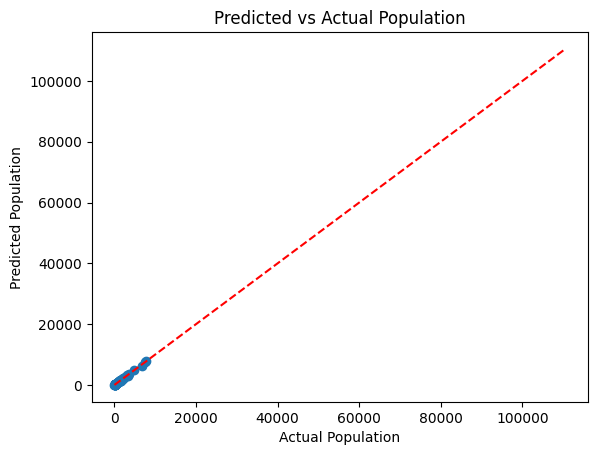

In [28]:
# Let's plot the predicted vs actual values
plt.scatter(yVal, yPred)
# Add a line for perfect correlation
plt.plot([y.min(), y.max()], [y.min(), y.max()],  '--', color='red')
plt.xlabel('Actual Population')
plt.ylabel('Predicted Population')
plt.title('Predicted vs Actual Population')

# As with the other plots, let's save things to our figures folder
plt.savefig(f'./figures/predicting_vs_actual_census_only_{dataSetName}.png')


In [29]:
X.head(50)

,% of owner households spending 30% or more of its income on shelter costs,% of owner households with a mortgage,% of tenant households in subsidized housing,% of tenant households spending 30% or more of its income on shelter costs,0 Management occupations,0 to 14 years,0 to 17 years,0 to 17 years (%),0 to 4 years,0 to 5 years,...,Total labour force population aged 15 years and over by occupation - National Occupational Classification (NOC) 2016 - 25% sample data,Total number of census families in private households - 100% data,Total population aged 15 years and over by work activity during the reference year - 25% sample data,Total visible minority population,Two-or-more person non-census-family households,Under 5 years,Unemployed,Unemployment rate,With employment income,Without employment income
0,NaN,30.8,0.0,NaN,0.0,10.0,NaN,NaN,0.0,NaN,...,75.0,50.0,145.0,10.0,0.0,0.0,25.0,33.3,NaN,NaN
1,0.0,50.0,0.0,0.0,10.0,55.0,65.0,7.7,10.0,15.0,...,195.0,105.0,295.0,0.0,0.0,0.0,120.0,61.5,195.0,60.0
2,9.5,65.1,0.0,0.0,35.0,90.0,110.0,9.1,25.0,30.0,...,285.0,200.0,460.0,0.0,5.0,0.0,25.0,8.8,335.0,150.0
3,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,5.0,NaN,...,45.0,30.0,75.0,0.0,0.0,0.0,15.0,33.3,NaN,NaN
4,4.7,43.1,42.9,0.0,45.0,115.0,155.0,12.9,30.0,40.0,...,520.0,290.0,780.0,0.0,10.0,0.0,130.0,25.0,555.0,240.0
5,13.3,48.9,0.0,50.0,10.0,90.0,120.0,20.8,25.0,30.0,...,295.0,190.0,525.0,0.0,10.0,0.0,45.0,15.5,365.0,180.0
6,14.3,48.2,40.0,60.0,15.0,90.0,120.0,12.5,15.0,25.0,...,325.0,240.0,615.0,0.0,5.0,0.0,55.0,17.2,395.0,220.0
7,3.6,38.1,19.2,26.9,50.0,205.0,240.0,12.5,60.0,80.0,...,585.0,425.0,1055.0,10.0,10.0,0.0,105.0,17.9,735.0,325.0
8,NaN,40.0,0.0,NaN,0.0,20.0,NaN,NaN,10.0,NaN,...,60.0,45.0,120.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
9,9.7,64.5,0.0,0.0,10.0,85.0,100.0,10.0,25.0,30.0,...,230.0,150.0,365.0,0.0,5.0,0.0,20.0,8.7,275.0,100.0


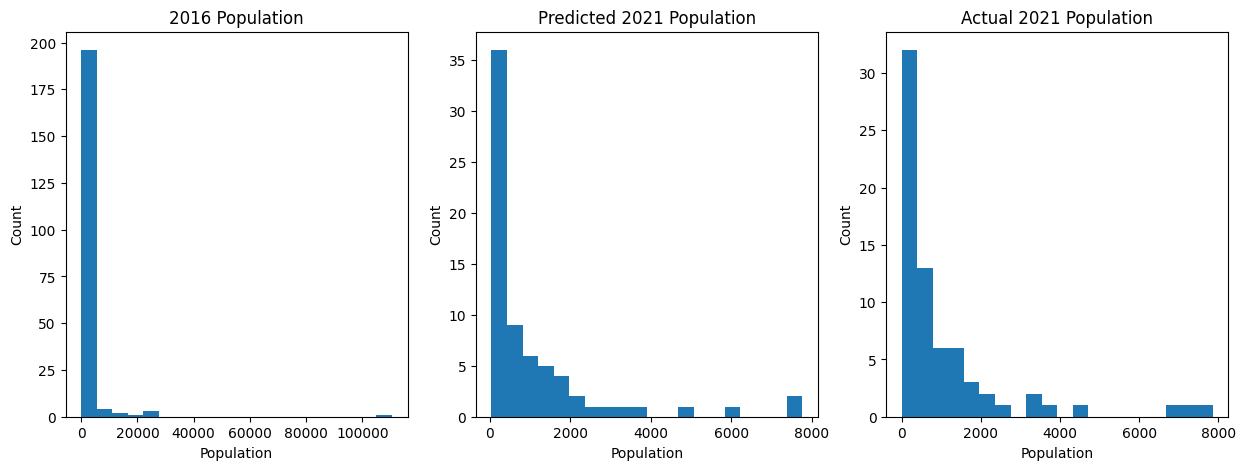

In [30]:
# Let's also plot the 2016 distribution, the predicted distribution, and the actual distribution
# as a set of subplots.
# This will let us see how the communities changed over time
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
dataSets = [yTrain, yPred, yVal]
titles = ['2016 Population', 'Predicted 2021 Population', 'Actual 2021 Population']
for i in range(3):
    axs[i].hist(dataSets[i], bins=20)
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('Population')
    axs[i].set_ylabel('Count')

# Let's save the plot in our figures folder
plt.savefig(f'./figures/predictions_census_only_{dataSetName}.png')



In [19]:
# To explore the data further, let's look at the feature importances
importances = model.named_steps['regressor'].feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]
print(importances[indices])

[2.56944558e-02 2.52132054e-02 2.21770731e-02 2.09245959e-02
 1.97593730e-02 1.69246920e-02 1.65464576e-02 1.65315053e-02
 1.64111380e-02 1.63559997e-02 1.57728600e-02 1.56782638e-02
 1.55401862e-02 1.54850026e-02 1.46136060e-02 1.45663678e-02
 1.43894720e-02 1.37594202e-02 1.34356508e-02 1.34240455e-02
 1.30789112e-02 1.24094620e-02 1.18970131e-02 1.17891510e-02
 1.16939429e-02 1.15524805e-02 1.11939374e-02 1.08334084e-02
 1.07761089e-02 1.07483328e-02 1.05434103e-02 1.04171213e-02
 1.02033460e-02 1.01499850e-02 1.00223435e-02 1.00159343e-02
 9.94040739e-03 9.86217609e-03 9.81155623e-03 9.69720034e-03
 9.62618882e-03 9.57455836e-03 9.43751102e-03 9.36019827e-03
 9.29686613e-03 9.28316430e-03 9.15046164e-03 8.95032672e-03
 8.83222801e-03 8.59051329e-03 8.45208591e-03 8.37824782e-03
 8.37478500e-03 8.34493769e-03 8.23564292e-03 8.17967978e-03
 8.13151602e-03 8.07043605e-03 7.92930587e-03 7.87633253e-03
 7.86453425e-03 7.77739908e-03 7.73592896e-03 7.56676243e-03
 7.50713163e-03 7.461623

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,
         3., 30.,  8.,  2.,  0.,  0.,  1.]),
 array([-21384. , -19934.6, -18485.2, -17035.8, -15586.4, -14137. ,
        -12687.6, -11238.2,  -9788.8,  -8339.4,  -6890. ,  -5440.6,
         -3991.2,  -2541.8,  -1092.4,    357. ,   1806.4,   3255.8,
          4705.2,   6154.6,   7604. ]),
 <BarContainer object of 20 artists>)

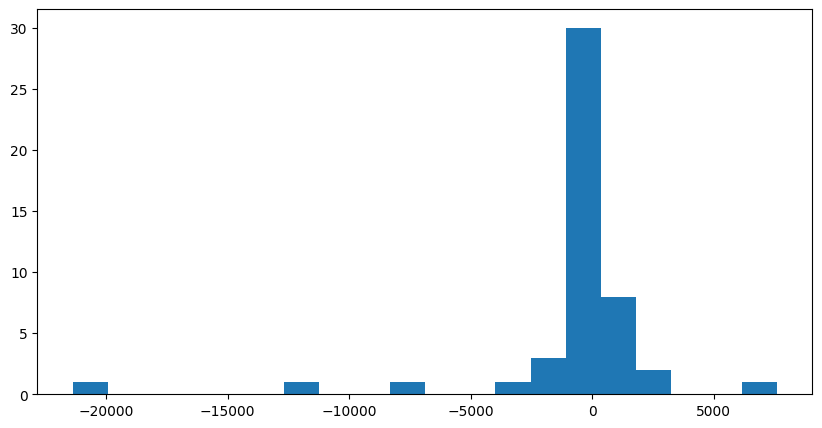

In [31]:
# Let's also look at the change in population for each community, and plot that
trimmed2016['Population Change'] = yVal - trimmed2016['Population, 2016']

# We'll plot this as a histogram
plt.figure(figsize=(10, 5))
plt.hist(trimmed2016['Population Change'], bins=20)

In [22]:
# Let's train our model using the road network data and the 2021 population targets
# First we will need to import the roadCharacteristics file

networks = pd.read_csv('./processedData/networkCharacteristics.csv')
networks.head()

,Unnamed: 0,Node Connectivity,Betweenness Centrality,Average Node Degree,Top 10% BC
0,Aberdeen,1,"{1638571580: 0.0, 1638571707: 0.02531645569620...",4.550000,0.505883
1,Acadieville,1,"{1665424050: 0.0, 1665425717: 0.0, 1665427309:...",4.203390,0.506352
2,Addington,0,"{604124914: 0.1076792705080486, 1020806170: 0....",5.054902,0.162141
3,Alma,1,"{16878195: 0.4796404019037546, 857586389: 0.20...",4.063492,0.469240
4,Alnwick,1,"{1729459293: 0.0, 1729460255: 0.01059597042722...",4.518519,0.281422


In [23]:
# First we will need to rename the first column, and match the community names to the appropriate 2021 data
networks = networks.rename(columns={'Unnamed: 0': 'GEO_NAME'})
trimmedNetworks = networks[networks['GEO_NAME'].isin(trimmed2021['GEO_NAME'])]
trimmedNetworks.shape

# Next we will trim the 2021 data to match the trimmed networks community names
populationForNetworks2021 = trimmed2021[trimmed2021['GEO_NAME'].isin(trimmedNetworks['GEO_NAME'])]

# And then we need to reorder, as we did when working with the census data
populationForNetworks2021 = populationForNetworks2021.sort_values(by='GEO_NAME')
trimmedNetworks = trimmedNetworks.sort_values(by='GEO_NAME')

print(populationForNetworks2021.shape)
print(trimmedNetworks.shape)



(169, 2)
(169, 5)


In [24]:
# Now we can train our model. We will use the road network data as our X values and the 2021 data as our y values.
# From the road networks, we will use Node Connectivity, average node degree, and top 10% BC
XNetworks = trimmedNetworks.drop(columns=['GEO_NAME', 'Betweenness Centrality'])
yNetworks = populationForNetworks2021['Population, 2021']

# Split the training data into training and validation sets
XTrainNetworks, XValNetworks, yTrainNetworks, yValNetworks = train_test_split(XNetworks, yNetworks, test_size=0.2, random_state=314159)

# We can use a similar pipeline to before, but we will need to define a new preprocessor for the network data
numericTransformerNetworks = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler())
])

preprocessorNetworks = ColumnTransformer(
    transformers=[
        ('num', numericTransformerNetworks, XNetworks.columns)
    ]
)

# Now we can set up our model
# We'll use a random forest regressor as before
networkTrees = 100
networkRegressor = RandomForestRegressor(n_estimators=networkTrees, random_state=314159)
networkModel = Pipeline(steps=[
    ('preprocessor', preprocessorNetworks),
    ('regressor', networkRegressor)
])


In [25]:
# Now we can train our model
networkModel.fit(XTrainNetworks, yTrainNetworks)
None

In [26]:
# Predict our values
yPredNetworks = networkModel.predict(XValNetworks)

# Calculate the root mean squared error
valRmseNetworks = np.sqrt(mean_squared_error(yValNetworks, yPredNetworks, squared=False))
# Calculate the R^2 value
valR2Networks = r2_score(yValNetworks, yPredNetworks)

print(f'Validation RMSE: {valRmseNetworks}')
print(f'Validation R^2: {valR2Networks}')

Validation RMSE: 73.7730245110908
Validation R^2: 0.742467139591463


c:\Users\danes\Documents\ACENETMicrocredentialinAdvancedComputing\ISP\CommunityGrowthPrediction\ispEnv\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Mean of validation set: 2829
Validation RMSE as a percentage of the mean: 2.61%


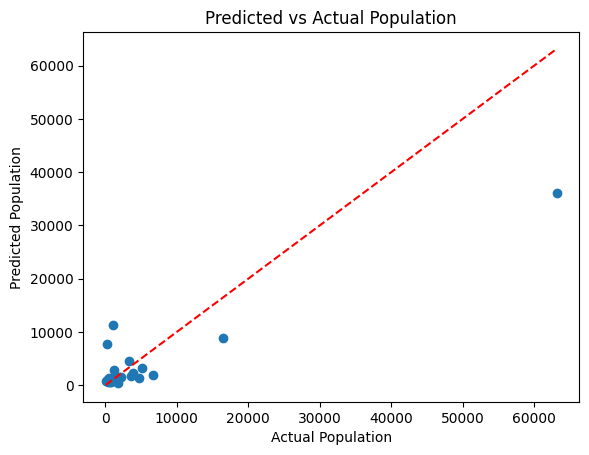

In [27]:
# Again, let's compare with the mean of the training data
print(f'Mean of validation set: {round(yTrainNetworks.mean())}')
print(f'Validation RMSE as a percentage of the mean: {round(valRmseNetworks / yTrainNetworks.mean() * 100, 2)}%')

# Let's plot the predicted vs actual values
plt.scatter(yValNetworks, yPredNetworks)
# Add a line for perfect correlation
plt.plot([yValNetworks.min(), yValNetworks.max()], [yValNetworks.min(), yValNetworks.max()],  '--', color='red')
plt.xlabel('Actual Population')
plt.ylabel('Predicted Population')
plt.title('Predicted vs Actual Population')
plt.savefig('./figures/predicting_vs_actual_networks_only.png')

In [ ]:
# Predict with RN + Census
# Predict for a different province

# Train on Canada and repeat